In [2]:
%reset
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL
import pickle as pk
import readfof
import matplotlib

import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline


%load_ext Cython

# # This routine computes the density field and save results to file
# def compute_df(snapshot, ptypes, grid, fout):
#     # if not(os.path.exists(snapshot+'.0')) and not(os.path.exists(snapshot+'.0.hdf5')):
#         # return 0
#     print(snapshot)
#     df = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
#                                    do_RSD=False, axis=0, verbose=True)
#     df = df/np.mean(df, dtype=np.float64)-1.0
#     np.save(fout, df)
    

    
    


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
%%cython

cimport numpy as np
cpdef void NGP_mass(np.float32_t[:,:] pos, np.float32_t[:] logM, np.float32_t[:,:,:,:] gridM, float BoxSize):

    cdef int axis,dims,coord,nMmax,jM
    cdef long i,particles
    cdef float inv_cell_size
    cdef int index[3]

    # find number of particles, the inverse of the cell size and dims
    particles = pos.shape[0];  coord = pos.shape[1];  dims = gridM.shape[0]; nMmax = gridM.shape[3]
    inv_cell_size = dims/BoxSize

    # when computing things in 2D, use the index[2]=0 plane
    for i in range(3):  index[i] = 0

    # do a loop over all particles
    for i in range(particles):
        for axis in range(coord):
            index[axis] = <int>(pos[i,axis]*inv_cell_size + 0.5)
            index[axis] = (index[axis]+dims)%dims
        for jM in range(nMmax):
            if gridM[index[0],index[1],index[2], jM] == 0:
                gridM[index[0],index[1],index[2], jM] = logM[i]
                break
            else:
                pass
        
        
        

In [9]:
# %pip install Pylians
root         = '/pscratch/sd/s/spandey/quijote/Snapshot_fid'
root_out     = '/pscratch/sd/s/spandey/quijote/data_NGP_self'
ptypes       = [1]
# snapnum      = 0
# grids         = [64, 128, 256, 512]
grids         = [64, 128, 256]
BoxSize = 1000.0 #Mpc/h ; size of box
n_batch = 8
n_filter = 3
# n_cnn_all = [0,5,7]
n_cnn_all = [3]
# n_sim_tot = 2
n_sim_array = np.arange(0,10)
snap_num_array = [-1,0,1,2,3,4]
# snap_num_array = [-1]
# i = 0
# print(i)
for ji in n_sim_array:
    print('doing sim: ' + str(ji))
    for grid in grids:
        print('doing res: ' + str(grid))
        for snapnum in snap_num_array:
            z = {4:0, 3:0.5, 2:1, 1:2, 0:3, -1: 127}[snapnum]

            # create output folder if it does not exists
            folder_out = '%s/%d'%(root_out,ji)
            if not(os.path.exists(folder_out)):
                os.system('mkdir %s'%folder_out)

            
            savefname_halos_subvol = '%s/halos_subvol_res_%d_z=%s.pk'%(folder_out,grid,z)
            savefname_halos_full = '%s/halos_full_res_%d_z=%s.pk'%(folder_out,grid,z)            
            
            
            # savefname = folder_out  + '/halo_density_data_dict_' + str(grid) + '.pk'
            # if os.path.exists(fout):  continue

            # compute the density field and save it to file
            if snapnum > 0:
                snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,ji,snapnum,snapnum)
            else:
                snapshot = '%s/%d/ICs/ics' % (root, ji)
            df_cic = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                                           do_RSD=False, axis=0, verbose=True)
            df_pylians_cic = df_cic/np.mean(df_cic, dtype=np.float64)-1.0
            
            
            df_ngp = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='NGP',
                                           do_RSD=False, axis=0, verbose=True)
            df_pylians_ngp = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
            
            if snapnum > 0:
                snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
                snapdir = snap_dir_base + '/' + str(ji)  #folder hosting the catalogue
                FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)

                # get the properties of the halos
                pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
                mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

                lgMass_truth = np.log10(mass_truth)

                Nhalos = np.float32(np.zeros((grid, grid, grid)))
                MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)

                if grid == 64:
                    nMax_h = 30  # maximum number of halos expected in a cell
                elif grid == 128:
                    nMax_h = 10
                elif grid == 256:
                    nMax_h = 5
                elif grid == 512:
                    nMax_h = 3
                elif grid == 1024:
                    nMax_h = 2
                else:
                    print('nside not supported')
                    sys.exit()

                dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
                NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)


                M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)


                # now split it into nbatches each side

                subvol_size = grid // n_batch
                nsubvol = n_batch**3
                save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
                save_subvol_density_cic_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                save_subvol_density_ngp_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))

                jc = 0
                from tqdm import tqdm
                for jx in tqdm(range(n_batch)):
                    for jy in range(n_batch):
                        for jz in range(n_batch):
                            # get the sub-cube
                            save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
                                                           jy * subvol_size:(jy + 1) * subvol_size,
                                                           jz * subvol_size:(jz + 1) * subvol_size]
                            save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                                            jy * subvol_size:(jy + 1) * subvol_size,
                                                            jz * subvol_size:(jz + 1) * subvol_size]
                            save_subvol_density_cic_unpad[jc] = df_pylians_cic[jx * subvol_size:(jx + 1) * subvol_size,
                                                           jy * subvol_size:(jy + 1) * subvol_size,
                                                           jz * subvol_size:(jz + 1) * subvol_size]
                            save_subvol_density_ngp_unpad[jc] = df_pylians_ngp[jx * subvol_size:(jx + 1) * subvol_size,
                                                           jy * subvol_size:(jy + 1) * subvol_size,
                                                           jz * subvol_size:(jz + 1) * subvol_size]                        
                            jc += 1

                saved_halos_subvol = {
                    'N_halos': save_subvol_Nhalo,
                    'M_halos': save_subvol_Mhalo,
                    }    
                pk.dump(saved_halos_subvol, open(savefname_halos_subvol, 'wb'))

                saved_halos_full = {
                    'N_halos_combined': Nhalos,
                    'M_halos_combined': M_halos,
                    }    
                pk.dump(saved_halos_full, open(savefname_halos_full, 'wb'))
                        

            for n_cnn in n_cnn_all:
                # find name of output file
                savefname_density_subvol = '%s/density_subvol_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)
                savefname_density_full = '%s/density_full_m_res_%d_z=%s_nbatch_%d_nfilter_%d_ncnn_%d.pk'%(folder_out,grid,z,n_batch,n_filter,n_cnn)

                n_dim_red = (n_filter - 1) // 2
                n_pad = n_dim_red * n_cnn
                if n_cnn > 0:
                    
                    df_cic_pad = np.pad(df_pylians_cic, n_pad, 'wrap')
                    df_ngp_pad = np.pad(df_pylians_ngp, n_pad, 'wrap')
                else:
                    df_cic_pad = df_pylians_cic
                    df_ngp_pad = df_pylians_ngp

                # we want to split the df_pad into n_batch^3 sub-cubes, but centered on the original df simulation box
                xstart, ystart, zstart = n_pad, n_pad, n_pad
                subvol_size = grid // n_batch + 2 * n_pad
                nsubvol = n_batch**3
                save_subvol_density_cic_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                save_subvol_density_ngp_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
                jc = 0
                from tqdm import tqdm
                for jx in tqdm(range(n_batch)):
                    for jy in range(n_batch):
                        for jz in range(n_batch):
                            # get the sub-cube
                            df_sub = df_cic_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                            ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                            zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                            # save the sub-cube
                            save_subvol_density_cic_pad[jc, ...] = df_sub

                            df_sub = df_ngp_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                                            ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                                            zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
                            # save the sub-cube
                            save_subvol_density_ngp_pad[jc, ...] = df_sub

                            jc += 1




                saved_density_subvol = {
                    'density_cic_pad':save_subvol_density_cic_pad,
                    'density_ngp_pad':save_subvol_density_ngp_pad,
                    'density_cic_unpad':save_subvol_density_cic_unpad,
                    'density_ngp_unpad':save_subvol_density_ngp_unpad,

                    }                        

                pk.dump(saved_density_subvol, open(savefname_density_subvol, 'wb'))

                saved_density_full = {
                    'density_cic_unpad_combined':df_pylians_cic,
                    'density_ngp_unpad_combined':df_pylians_ngp,                                
                    'density_cic_pad_combined':df_cic_pad,
                    'density_ngp_pad_combined':df_ngp_pad,                                                
                    }                        

                pk.dump(saved_density_full, open(savefname_density_full, 'wb'))


                


doing sim: 0
doing res: 64

Computing density field of particles [1]
1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 2.80 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 2255.31it/s]


Computing density field of particles [1]


1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 2.31 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 2524.03it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.85 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.50 seconds


100%|██████████| 8/8 [00:00<00:00, 2222.88it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.83 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.22 seconds


100%|██████████| 8/8 [00:00<00:00, 2136.54it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.66 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.21 seconds


100%|██████████| 8/8 [00:00<00:00, 2299.04it/s]



Computing density field of particles [1]
1.34217724e+08 should be equal to
1.34217728e+08
Time taken = 2.74 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.18 seconds


100%|██████████| 8/8 [00:00<00:00, 2293.22it/s]


doing res: 128

Computing density field of particles [1]
1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.47 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.32 seconds


100%|██████████| 8/8 [00:00<00:00, 536.66it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.32 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.37 seconds


100%|██████████| 8/8 [00:00<00:00, 534.41it/s]


Computing density field of particles [1]


1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.28 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.22 seconds


100%|██████████| 8/8 [00:00<00:00, 537.57it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.24 seconds


100%|██████████| 8/8 [00:00<00:00, 529.32it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.29 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.25 seconds


100%|██████████| 8/8 [00:00<00:00, 517.58it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.28 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.24 seconds


100%|██████████| 8/8 [00:00<00:00, 515.65it/s]


doing res: 256

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.41 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.38 seconds


100%|██████████| 8/8 [00:00<00:00, 120.19it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.39 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.40 seconds


100%|██████████| 8/8 [00:00<00:00, 120.34it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.35 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.31 seconds


100%|██████████| 8/8 [00:00<00:00, 123.86it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.27 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.31 seconds


100%|██████████| 8/8 [00:00<00:00, 123.68it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 120.66it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.31 seconds


100%|██████████| 8/8 [00:00<00:00, 120.94it/s]


doing sim: 1
doing res: 64

Computing density field of particles [1]
1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 2.94 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.37 seconds


100%|██████████| 8/8 [00:00<00:00, 2405.34it/s]


Computing density field of particles [1]


1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 2.38 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.36 seconds


100%|██████████| 8/8 [00:00<00:00, 2242.94it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.74 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.21 seconds


100%|██████████| 8/8 [00:00<00:00, 2223.03it/s]


Computing density field of particles [1]


1.34217724e+08 should be equal to
1.34217728e+08
Time taken = 2.75 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.22 seconds


100%|██████████| 8/8 [00:00<00:00, 2216.13it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.80 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.24 seconds


100%|██████████| 8/8 [00:00<00:00, 2432.19it/s]



Computing density field of particles [1]
1.34217724e+08 should be equal to
1.34217728e+08
Time taken = 2.78 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.24 seconds


100%|██████████| 8/8 [00:00<00:00, 2261.23it/s]


doing res: 128

Computing density field of particles [1]
1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.37 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.31 seconds


100%|██████████| 8/8 [00:00<00:00, 552.64it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.31 seconds


100%|██████████| 8/8 [00:00<00:00, 553.48it/s]


Computing density field of particles [1]


1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.16 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.19 seconds


100%|██████████| 8/8 [00:00<00:00, 538.73it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.23 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.20 seconds


100%|██████████| 8/8 [00:00<00:00, 532.64it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.16 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.19 seconds


100%|██████████| 8/8 [00:00<00:00, 520.78it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.24 seconds


100%|██████████| 8/8 [00:00<00:00, 526.14it/s]


doing res: 256

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.27 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 74.53it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.28 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.34 seconds


100%|██████████| 8/8 [00:00<00:00, 72.70it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.17 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.27 seconds


100%|██████████| 8/8 [00:00<00:00, 117.55it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.21 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.26 seconds


100%|██████████| 8/8 [00:00<00:00, 121.33it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.29 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.28 seconds


100%|██████████| 8/8 [00:00<00:00, 93.11it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.25 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.32 seconds


100%|██████████| 8/8 [00:00<00:00, 120.32it/s]


doing sim: 2
doing res: 64

Computing density field of particles [1]
1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 4.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.32 seconds


100%|██████████| 8/8 [00:00<00:00, 2518.72it/s]


Computing density field of particles [1]


1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 2.37 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.34 seconds


100%|██████████| 8/8 [00:00<00:00, 2449.59it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.68 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.18 seconds


100%|██████████| 8/8 [00:00<00:00, 2261.99it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.68 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.17 seconds


100%|██████████| 8/8 [00:00<00:00, 2397.77it/s]


Computing density field of particles [1]


1.34217724e+08 should be equal to
1.34217728e+08
Time taken = 2.67 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.17 seconds


100%|██████████| 8/8 [00:00<00:00, 2169.84it/s]



Computing density field of particles [1]
1.34217724e+08 should be equal to
1.34217728e+08
Time taken = 2.67 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.17 seconds


100%|██████████| 8/8 [00:00<00:00, 2290.87it/s]


doing res: 128

Computing density field of particles [1]
1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.32 seconds


100%|██████████| 8/8 [00:00<00:00, 542.87it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.27 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 553.70it/s]


Computing density field of particles [1]


1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.17 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.19 seconds


100%|██████████| 8/8 [00:00<00:00, 523.20it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.16 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.19 seconds


100%|██████████| 8/8 [00:00<00:00, 534.89it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.15 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.19 seconds


100%|██████████| 8/8 [00:00<00:00, 544.62it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.17 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.19 seconds


100%|██████████| 8/8 [00:00<00:00, 529.41it/s]


doing res: 256

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.30 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.35 seconds


100%|██████████| 8/8 [00:00<00:00, 124.31it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.29 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.35 seconds


100%|██████████| 8/8 [00:00<00:00, 124.85it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.18 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.28 seconds


100%|██████████| 8/8 [00:00<00:00, 120.65it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.28 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 123.19it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.27 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.32 seconds


100%|██████████| 8/8 [00:00<00:00, 120.62it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.31 seconds


100%|██████████| 8/8 [00:00<00:00, 120.87it/s]


doing sim: 3
doing res: 64

Computing density field of particles [1]
1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 4.15 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.36 seconds


100%|██████████| 8/8 [00:00<00:00, 2185.24it/s]


Computing density field of particles [1]


1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 2.37 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 2408.44it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.78 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.22 seconds


100%|██████████| 8/8 [00:00<00:00, 2224.21it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.77 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.23 seconds


100%|██████████| 8/8 [00:00<00:00, 2113.27it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.74 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.18 seconds


100%|██████████| 8/8 [00:00<00:00, 2281.68it/s]



Computing density field of particles [1]
1.34217724e+08 should be equal to
1.34217728e+08
Time taken = 2.70 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.20 seconds


100%|██████████| 8/8 [00:00<00:00, 2282.46it/s]


doing res: 128

Computing density field of particles [1]
1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.33 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 560.35it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.31 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.37 seconds


100%|██████████| 8/8 [00:00<00:00, 553.79it/s]


Computing density field of particles [1]


1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.22 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.25 seconds


100%|██████████| 8/8 [00:00<00:00, 540.40it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.19 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.22 seconds


100%|██████████| 8/8 [00:00<00:00, 680.78it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.25 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.23 seconds


100%|██████████| 8/8 [00:00<00:00, 534.11it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.20 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.23 seconds


100%|██████████| 8/8 [00:00<00:00, 524.75it/s]


doing res: 256

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.35 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.35 seconds


100%|██████████| 8/8 [00:00<00:00, 67.29it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.35 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.35 seconds


100%|██████████| 8/8 [00:00<00:00, 66.69it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.29 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.36 seconds


100%|██████████| 8/8 [00:00<00:00, 64.74it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 3.00 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.32 seconds


100%|██████████| 8/8 [00:00<00:00, 119.41it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.75 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.30 seconds


100%|██████████| 8/8 [00:00<00:00, 120.88it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.73 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.31 seconds


100%|██████████| 8/8 [00:00<00:00, 123.43it/s]


doing sim: 4
doing res: 64

Computing density field of particles [1]
1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 4.22 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 2495.50it/s]


Computing density field of particles [1]


1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 2.36 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.34 seconds


100%|██████████| 8/8 [00:00<00:00, 2506.87it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.73 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.20 seconds


100%|██████████| 8/8 [00:00<00:00, 2162.71it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.76 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.38 seconds


100%|██████████| 8/8 [00:00<00:00, 2125.85it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.79 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.18 seconds


100%|██████████| 8/8 [00:00<00:00, 2301.56it/s]



Computing density field of particles [1]
1.34217724e+08 should be equal to
1.34217728e+08
Time taken = 2.70 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.20 seconds


100%|██████████| 8/8 [00:00<00:00, 2288.84it/s]


doing res: 128

Computing density field of particles [1]
1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.33 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.34 seconds


100%|██████████| 8/8 [00:00<00:00, 555.67it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.31 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.34 seconds


100%|██████████| 8/8 [00:00<00:00, 540.19it/s]


Computing density field of particles [1]


1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.21 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.23 seconds


100%|██████████| 8/8 [00:00<00:00, 525.00it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.28 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.27 seconds


100%|██████████| 8/8 [00:00<00:00, 519.32it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.27 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.24 seconds


100%|██████████| 8/8 [00:00<00:00, 509.67it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.23 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.23 seconds


100%|██████████| 8/8 [00:00<00:00, 517.01it/s]


doing res: 256

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.36 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.39 seconds


100%|██████████| 8/8 [00:00<00:00, 120.98it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.37 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.37 seconds


100%|██████████| 8/8 [00:00<00:00, 122.47it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.28 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 122.25it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.35 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.41 seconds


100%|██████████| 8/8 [00:00<00:00, 118.54it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.27 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.34 seconds


100%|██████████| 8/8 [00:00<00:00, 117.23it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.38 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.37 seconds


100%|██████████| 8/8 [00:00<00:00, 116.96it/s]


doing sim: 5
doing res: 64

Computing density field of particles [1]
1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 4.20 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.44 seconds


100%|██████████| 8/8 [00:00<00:00, 2111.27it/s]


Computing density field of particles [1]


1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 2.51 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.43 seconds


100%|██████████| 8/8 [00:00<00:00, 2299.82it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.95 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.29 seconds


100%|██████████| 8/8 [00:00<00:00, 2218.47it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.87 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.27 seconds


100%|██████████| 8/8 [00:00<00:00, 1758.89it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.87 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.28 seconds


100%|██████████| 8/8 [00:00<00:00, 2298.56it/s]



Computing density field of particles [1]
1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.88 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.26 seconds


100%|██████████| 8/8 [00:00<00:00, 2303.61it/s]


doing res: 128

Computing density field of particles [1]
1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.48 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.44 seconds


100%|██████████| 8/8 [00:00<00:00, 515.86it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.50 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.45 seconds


100%|██████████| 8/8 [00:00<00:00, 505.60it/s]


Computing density field of particles [1]


1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.40 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.32 seconds


100%|██████████| 8/8 [00:00<00:00, 514.75it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.38 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.30 seconds


100%|██████████| 8/8 [00:00<00:00, 514.44it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.37 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.29 seconds


100%|██████████| 8/8 [00:00<00:00, 517.59it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.36 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.30 seconds


100%|██████████| 8/8 [00:00<00:00, 502.18it/s]


doing res: 256

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.51 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.47 seconds


100%|██████████| 8/8 [00:00<00:00, 116.70it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.32 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.36 seconds


100%|██████████| 8/8 [00:00<00:00, 122.50it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.21 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.30 seconds


100%|██████████| 8/8 [00:00<00:00, 121.50it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.21 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.30 seconds


100%|██████████| 8/8 [00:00<00:00, 124.00it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.23 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.29 seconds


100%|██████████| 8/8 [00:00<00:00, 123.84it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.32 seconds


100%|██████████| 8/8 [00:00<00:00, 122.88it/s]


doing sim: 6
doing res: 64

Computing density field of particles [1]
1.34217697e+08 should be equal to
1.34217728e+08
Time taken = 4.15 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.30 seconds


100%|██████████| 8/8 [00:00<00:00, 2408.62it/s]


Computing density field of particles [1]


1.34217697e+08 should be equal to
1.34217728e+08
Time taken = 2.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.28 seconds


100%|██████████| 8/8 [00:00<00:00, 2424.98it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.64 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.16 seconds


100%|██████████| 8/8 [00:00<00:00, 2264.90it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.71 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.19 seconds


100%|██████████| 8/8 [00:00<00:00, 2257.28it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.71 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.19 seconds


100%|██████████| 8/8 [00:00<00:00, 2258.04it/s]



Computing density field of particles [1]
1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.68 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.16 seconds


100%|██████████| 8/8 [00:00<00:00, 2227.01it/s]


doing res: 128

Computing density field of particles [1]
1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.28 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.32 seconds


100%|██████████| 8/8 [00:00<00:00, 557.84it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.33 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.35 seconds


100%|██████████| 8/8 [00:00<00:00, 535.66it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.25 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.21 seconds


100%|██████████| 8/8 [00:00<00:00, 535.70it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.18 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.23 seconds


100%|██████████| 8/8 [00:00<00:00, 536.23it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.24 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.24 seconds


100%|██████████| 8/8 [00:00<00:00, 522.22it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.23 seconds


100%|██████████| 8/8 [00:00<00:00, 515.23it/s]


doing res: 256

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.39 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.39 seconds


100%|██████████| 8/8 [00:00<00:00, 120.70it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.36 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.38 seconds


100%|██████████| 8/8 [00:00<00:00, 122.00it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.24 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.31 seconds


100%|██████████| 8/8 [00:00<00:00, 121.12it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.25 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.31 seconds


100%|██████████| 8/8 [00:00<00:00, 121.96it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 5.02 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.37 seconds


100%|██████████| 8/8 [00:00<00:00, 117.90it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.88 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 114.73it/s]


doing sim: 7
doing res: 64

Computing density field of particles [1]
1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 4.21 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.32 seconds


100%|██████████| 8/8 [00:00<00:00, 2358.67it/s]


Computing density field of particles [1]


1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 2.34 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.36 seconds


100%|██████████| 8/8 [00:00<00:00, 2335.52it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.75 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.18 seconds


100%|██████████| 8/8 [00:00<00:00, 2385.33it/s]


Computing density field of particles [1]


1.34217724e+08 should be equal to
1.34217728e+08
Time taken = 2.72 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.20 seconds


100%|██████████| 8/8 [00:00<00:00, 2301.24it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.75 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.21 seconds


100%|██████████| 8/8 [00:00<00:00, 2296.99it/s]


Computing density field of particles [1]


1.34217724e+08 should be equal to
1.34217728e+08
Time taken = 2.78 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.22 seconds


100%|██████████| 8/8 [00:00<00:00, 2286.66it/s]


doing res: 128

Computing density field of particles [1]
1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.32 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.37 seconds


100%|██████████| 8/8 [00:00<00:00, 532.80it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.33 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.41 seconds


100%|██████████| 8/8 [00:00<00:00, 525.74it/s]


Computing density field of particles [1]


1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.18 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.24 seconds


100%|██████████| 8/8 [00:00<00:00, 659.22it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.21 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.21 seconds


100%|██████████| 8/8 [00:00<00:00, 530.90it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.24 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.20 seconds


100%|██████████| 8/8 [00:00<00:00, 525.76it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.25 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.25 seconds


100%|██████████| 8/8 [00:00<00:00, 503.41it/s]


doing res: 256

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.39 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.39 seconds


100%|██████████| 8/8 [00:00<00:00, 121.45it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.33 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.40 seconds


100%|██████████| 8/8 [00:00<00:00, 122.11it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.28 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 122.69it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.23 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 122.60it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.25 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.31 seconds


100%|██████████| 8/8 [00:00<00:00, 120.89it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.27 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.36 seconds


100%|██████████| 8/8 [00:00<00:00, 117.97it/s]


doing sim: 8
doing res: 64

Computing density field of particles [1]
1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 4.15 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.35 seconds


100%|██████████| 8/8 [00:00<00:00, 2340.41it/s]


Computing density field of particles [1]


1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 2.38 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 2402.58it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.73 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.21 seconds


100%|██████████| 8/8 [00:00<00:00, 2283.24it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.76 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.19 seconds


100%|██████████| 8/8 [00:00<00:00, 2268.57it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.68 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.18 seconds


100%|██████████| 8/8 [00:00<00:00, 2016.37it/s]



Computing density field of particles [1]
1.34217724e+08 should be equal to
1.34217728e+08
Time taken = 2.73 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.19 seconds


100%|██████████| 8/8 [00:00<00:00, 2238.45it/s]


doing res: 128

Computing density field of particles [1]
1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.27 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.34 seconds


100%|██████████| 8/8 [00:00<00:00, 523.31it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.33 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.32 seconds


100%|██████████| 8/8 [00:00<00:00, 540.22it/s]


Computing density field of particles [1]


1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.20 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.24 seconds


100%|██████████| 8/8 [00:00<00:00, 526.21it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.23 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.21 seconds


100%|██████████| 8/8 [00:00<00:00, 549.36it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.19 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.20 seconds


100%|██████████| 8/8 [00:00<00:00, 550.39it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.18 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.20 seconds


100%|██████████| 8/8 [00:00<00:00, 525.36it/s]


doing res: 256

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.29 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.35 seconds


100%|██████████| 8/8 [00:00<00:00, 124.56it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.25 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.31 seconds


100%|██████████| 8/8 [00:00<00:00, 125.39it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.18 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.27 seconds


100%|██████████| 8/8 [00:00<00:00, 124.12it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.21 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.29 seconds


100%|██████████| 8/8 [00:00<00:00, 123.62it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.19 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.26 seconds


100%|██████████| 8/8 [00:00<00:00, 125.18it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.19 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.28 seconds


100%|██████████| 8/8 [00:00<00:00, 124.49it/s]


doing sim: 9
doing res: 64

Computing density field of particles [1]
1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 4.13 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.31 seconds


100%|██████████| 8/8 [00:00<00:00, 2491.79it/s]


Computing density field of particles [1]


1.34217698e+08 should be equal to
1.34217728e+08
Time taken = 2.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.30 seconds


100%|██████████| 8/8 [00:00<00:00, 2216.86it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.65 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.16 seconds


100%|██████████| 8/8 [00:00<00:00, 2169.98it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.66 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.17 seconds


100%|██████████| 8/8 [00:00<00:00, 2179.28it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.66 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.18 seconds


100%|██████████| 8/8 [00:00<00:00, 2358.67it/s]



Computing density field of particles [1]
1.34217724e+08 should be equal to
1.34217728e+08
Time taken = 2.67 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.16 seconds


100%|██████████| 8/8 [00:00<00:00, 2311.07it/s]


doing res: 128

Computing density field of particles [1]
1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.25 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.30 seconds


100%|██████████| 8/8 [00:00<00:00, 690.88it/s]


Computing density field of particles [1]


1.34217725e+08 should be equal to
1.34217728e+08
Time taken = 2.26 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.30 seconds


100%|██████████| 8/8 [00:00<00:00, 544.80it/s]


Computing density field of particles [1]


1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.19 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.20 seconds


100%|██████████| 8/8 [00:00<00:00, 528.06it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.18 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.20 seconds


100%|██████████| 8/8 [00:00<00:00, 524.89it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.17 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.20 seconds


100%|██████████| 8/8 [00:00<00:00, 538.41it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.19 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.20 seconds


100%|██████████| 8/8 [00:00<00:00, 529.85it/s]


doing res: 256

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.29 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.34 seconds


100%|██████████| 8/8 [00:00<00:00, 123.83it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.29 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.35 seconds


100%|██████████| 8/8 [00:00<00:00, 122.65it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.21 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.30 seconds


100%|██████████| 8/8 [00:00<00:00, 122.80it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.21 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.28 seconds


100%|██████████| 8/8 [00:00<00:00, 124.61it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.20 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.27 seconds


100%|██████████| 8/8 [00:00<00:00, 122.89it/s]



Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.28 seconds

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 1.33 seconds


100%|██████████| 8/8 [00:00<00:00, 120.89it/s]


In [27]:
# test that all the histograms look like as expected:
ji = 1
grid = 128
snapnum = 4
z = {4:0, 3:0.5, 2:1, 1:2, 0:3}[snapnum]
df_halos_full = pk.load(open('/pscratch/sd/s/spandey/quijote/data_NGP_self/' + str(ji) + '/halos_full_res_'+ str(grid) + '_z=' + str(z) + '.pk','rb')) 
df_halos_subvol = pk.load(open('/pscratch/sd/s/spandey/quijote/data_NGP_self/' + str(ji) + '/halos_subvol_res_'+ str(grid) + '_z=' + str(z) + '.pk','rb')) 
df_density_full = pk.load(open('/pscratch/sd/s/spandey/quijote/data_NGP_self/' + str(ji) + '/density_full_m_res_'+ str(grid) + '_z=' + str(z) + '.pk','rb')) 
df_density_subvol = pk.load(open('/pscratch/sd/s/spandey/quijote/data_NGP_self/' + str(ji) + '/density_subvol_m_res_'+ str(grid) + '_z=' + str(z) + '.pk','rb')) 





In [32]:
# df_pylians = df_density_full['density_cic_unpad_combined']
df_pylians = df_density_full['density_ngp_unpad_combined']
dfhalo2_ngp = df_halos_full['N_halos_combined']
dfhalo_ngp_wmass_sorted = df_halos_full['M_halos_combined']



In [33]:
dfhalo2_ngp.shape, df_pylians.shape


((128, 128, 128), (128, 128, 128))

Text(0.5, 1.0, '10.5$< \\delta_m < $50.4')

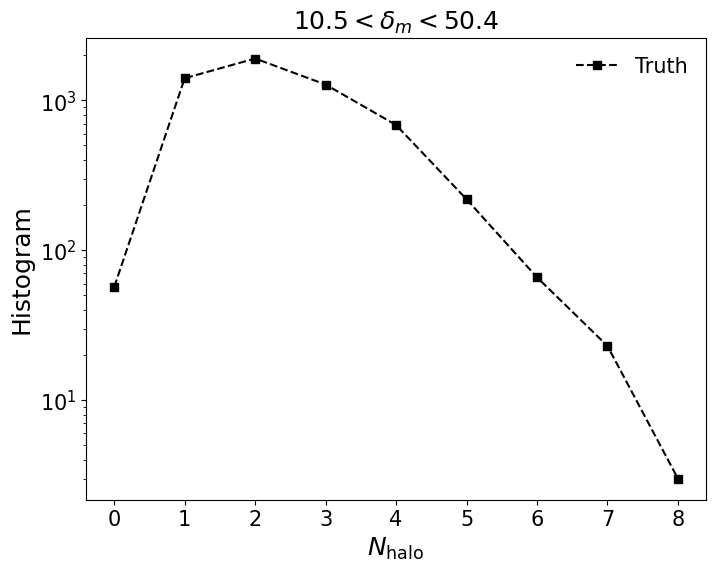

In [34]:
delta_min_p, delta_max_p = 10.5, 50.4
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
pl.figure(figsize=(8,6))
bin_cents = np.array([0,1,2,3,4,5,6,7,8])
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
bin_edges = np.insert(bin_edges,0, -0.5)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
hist_truth, _ = np.histogram(dfhalo2_ngp[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')
# hist_samp, _ = np.histogram(Nhalos_truth_recomb[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
# pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$N_{\rm halo}$', size=18)
pl.ylabel('Histogram', size=18)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




(0.0, 100.0)

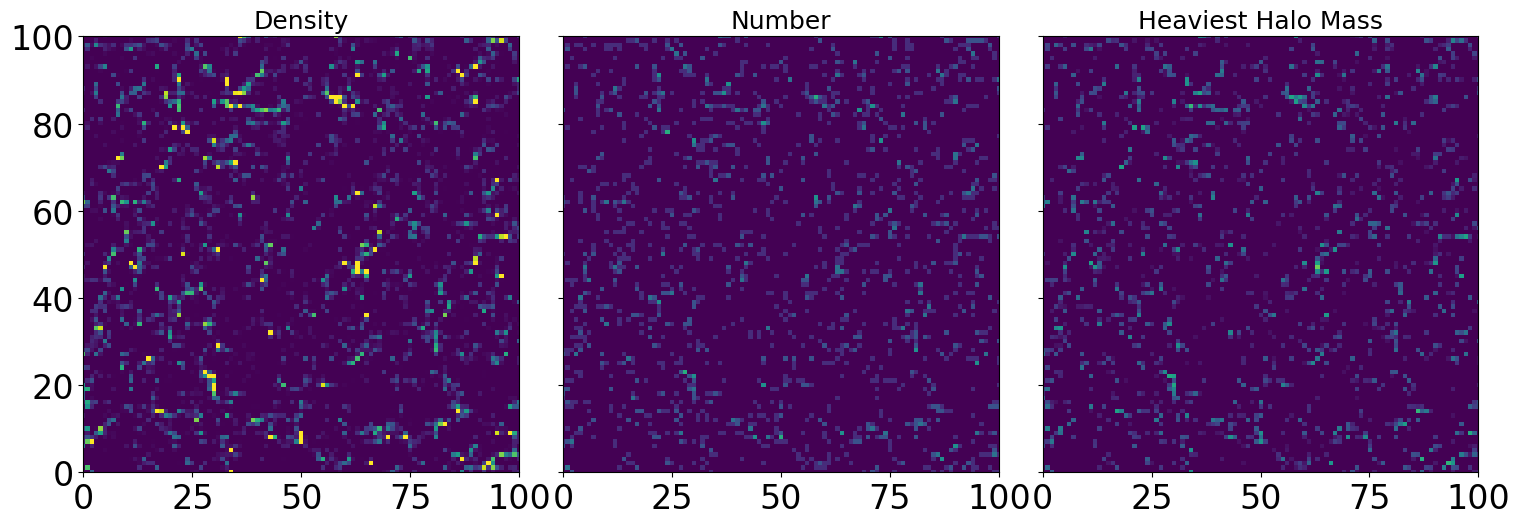

In [35]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 100
axes[0].imshow(df_pylians[64,:,:], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Density', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(dfhalo2_ngp[64,:,:], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Number', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(dfhalo_ngp_wmass_sorted[64,:,:, 0], vmin=13, vmax=16, origin='lower')
axes[2].set_title('Heaviest Halo Mass', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)





            


Text(0, 0.5, 'Histogram Density')

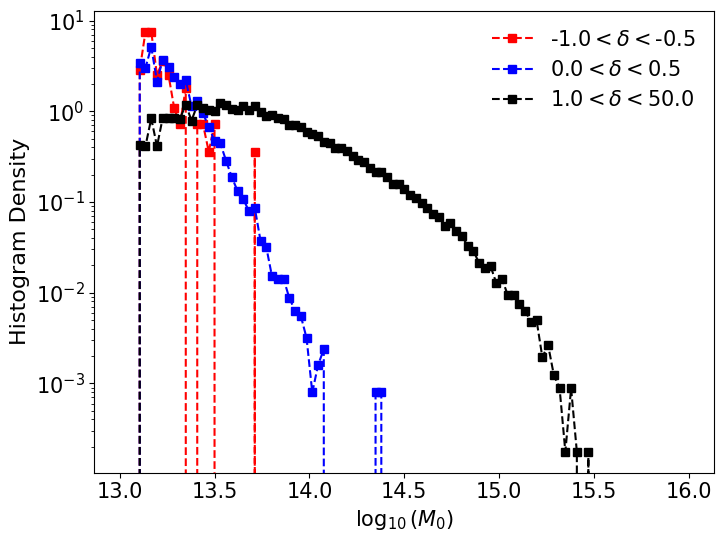

In [36]:
bin_edges = np.linspace(13, 16, 100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])


pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = -1.0, -0.5
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))

delta_min_p, delta_max_p = 0.0, 0.5
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))


delta_min_p, delta_max_p = 1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))


pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$\log_{10}(M_{0})$', size=15)
pl.ylabel('Histogram Density', size=16)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




Text(0.5, 1.0, '1.0$< \\delta_m < $50.0')

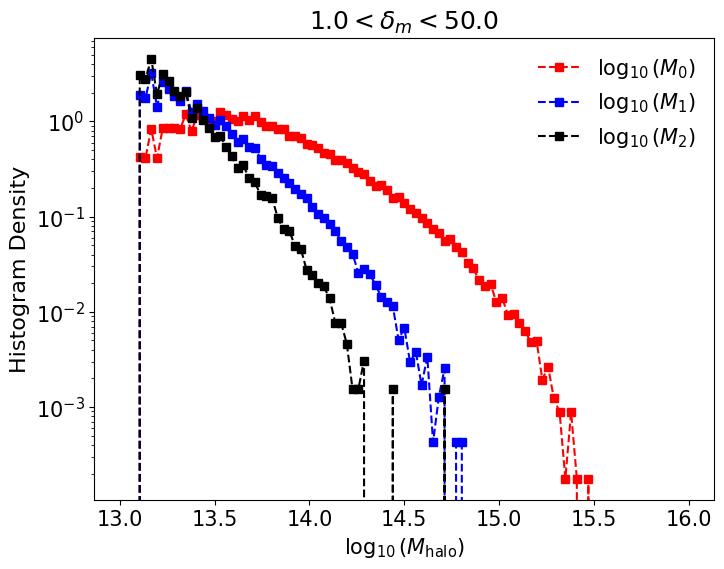

In [37]:
bin_edges = np.linspace(13, 16, 100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])


pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = 1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label=r'$\log_{10}(M_0)$')

hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,1][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label=r'$\log_{10}(M_1)$')

hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,2][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label=r'$\log_{10}(M_2)$')


pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel('Histogram Density', size=16)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




Text(0, 0.5, '$\\log_{10}(M_{0})$')

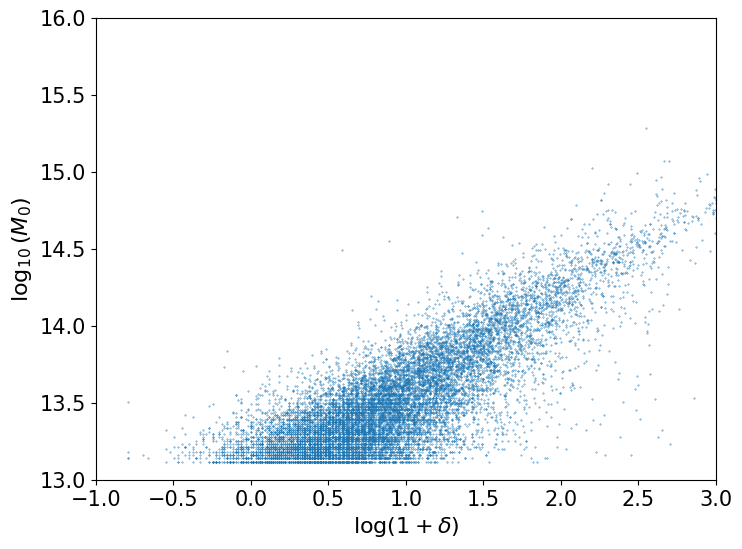

In [38]:
pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = -1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
density_list = df_pylians[indsel_dp].flatten()
logM_list = dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten()
indsel_rand = np.random.randint(0, len(density_list), np.amin(np.array([len(density_list), 100000])))
pl.scatter(np.log(1+density_list[indsel_rand]),logM_list[indsel_rand], s=0.1)
# pl.xscale('log')
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.ylim(13, 16)
pl.xlim(-1,3)
pl.xlabel(r'$\log(1 + \delta)$', size=16)
pl.ylabel(r'$\log_{10}(M_{0})$', size=16)

# pl.xlim(delta_min_p-0.1, delta_max_p)




In [41]:
save_subvol_density_pad = df_density_subvol['density_ngp_pad']
save_subvol_density_unpad = df_density_subvol['density_ngp_unpad']
save_subvol_Nhalo = df_halos_subvol['N_halos']
save_subvol_Mhalo = df_halos_subvol['M_halos']



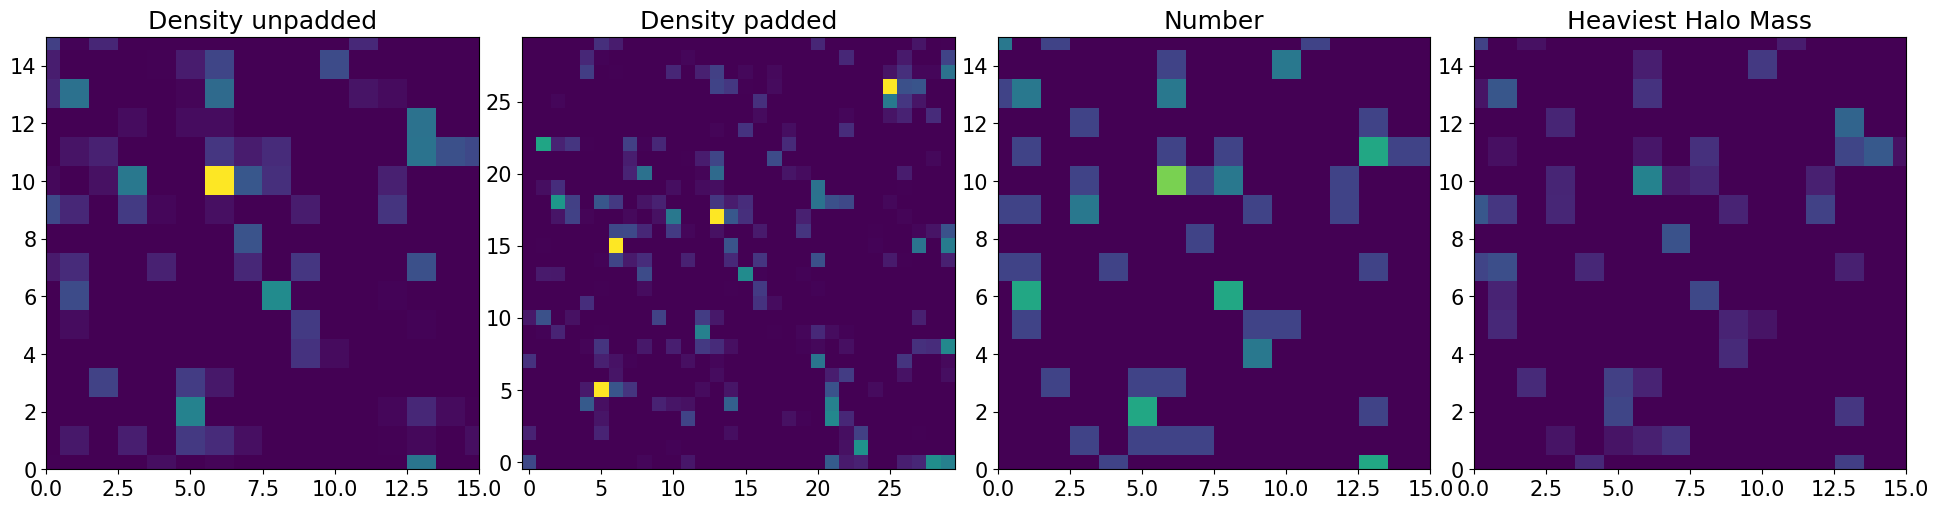

In [42]:
fig, axes = pl.subplots(nrows=1, ncols=4, figsize=(24, 8))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 15
axes[0].imshow(save_subvol_density_unpad[0,8,...], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Density unpadded', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[0].tick_params(axis='both', which='minor', labelsize=15)


axes[1].imshow(save_subvol_density_pad[0, n_pad + 8,...], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Density padded', size=18)
# axes[1].set_xlim(xmin+n_pad,xmax+n_pad)
# axes[1].set_ylim(xmin+n_pad,xmax+n_pad)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='minor', labelsize=15)


# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(save_subvol_Nhalo[0,8,...], vmin=0, vmax=5, origin='lower')
axes[2].set_title('Number', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)
axes[2].tick_params(axis='both', which='major', labelsize=15)
axes[2].tick_params(axis='both', which='minor', labelsize=15)


axes[3].imshow(save_subvol_Mhalo[..., 0][0,8,...], vmin=13, vmax=16, origin='lower')
axes[3].set_title('Heaviest Halo Mass', size=18)
axes[3].set_xlim(xmin,xmax)
axes[3].set_ylim(xmin,xmax)
axes[3].tick_params(axis='both', which='major', labelsize=15)
axes[3].tick_params(axis='both', which='minor', labelsize=15)





            



